# Task 1

In [ ]:
!pip install transformers datasets evaluate

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
import time

vocab_size = 10000
max_len = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

def build_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()

start_time = time.time()
rnn_model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.2)
rnn_time = time.time() - start_time

rnn_loss, rnn_acc = rnn_model.evaluate(x_test, y_test)
print(f"🧠 RNN Accuracy: {rnn_acc:.4f}, Time: {rnn_time:.2f} sec")

from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from datasets import load_dataset

dataset = load_dataset("imdb", split='train[:5000]')
dataset = dataset.train_test_split(test_size=0.2)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

encoded_dataset = dataset.map(tokenize_data, batched=True)
encoded_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'label'])

features = {
    'input_ids': tf.keras.Input(shape=(256,), dtype=tf.int32, name='input_ids'),
    'attention_mask': tf.keras.Input(shape=(256,), dtype=tf.int32, name='attention_mask')
}

transformer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

transformer_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

tf_train = encoded_dataset['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    shuffle=True,
    batch_size=8
)

tf_val = encoded_dataset['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    shuffle=False,
    batch_size=8
)

start_time = time.time()
transformer_model.fit(tf_train, validation_data=tf_val, epochs=2)
transformer_time = time.time() - start_time

transformer_loss, transformer_acc = transformer_model.evaluate(tf_val)
print(f"⚡ Transformer Accuracy: {transformer_acc:.4f}, Time: {transformer_time:.2f} sec")

print("====== COMPARISON REPORT ======")
print(f"RNN Model:\n - Accuracy: {rnn_acc:.4f}\n - Training Time: {rnn_time:.2f} sec")
print(f"Transformer Model (DistilBERT):\n - Accuracy: {transformer_acc:.4f}\n - Training Time: {transformer_time:.2f} sec")

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7021 - loss: 0.5512 - val_accuracy: 0.8070 - val_loss: 0.4525
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8794 - loss: 0.3137 - val_accuracy: 0.8702 - val_loss: 0.3123
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8588 - loss: 0.3285
🧠 RNN Accuracy: 0.8618, Time: 12.96 sec


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
500/500 [==============================] - 148s 246ms/step - loss: 0.0022 - accuracy: 0.9980 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
125/125 [==============================] - 10s 75ms/step - loss: 0.0000e+00 - accuracy: 1.0000
⚡ Transformer Accuracy: 1.0000, Time: 299.45 sec
====== COMPARISON REPORT ======
RNN Model:
 - Accuracy: 0.8618
 - Training Time: 12.96 sec
Transformer Model (DistilBERT):
 - Accuracy: 1.0000
 - Training Time: 299.45 sec


# Task 2

Attention Weights:
 tensor([[9.5750e-01, 1.1786e-03, 4.1321e-02],
        [9.8474e-01, 4.8090e-03, 1.0448e-02],
        [9.9549e-01, 8.5628e-05, 4.4251e-03]])
Output:
 tensor([[-2.9805,  0.1984, -1.1424,  1.0598],
        [-2.9473,  0.1579, -1.1165,  1.0855],
        [-2.9464,  0.1322, -1.1073,  1.1103]])


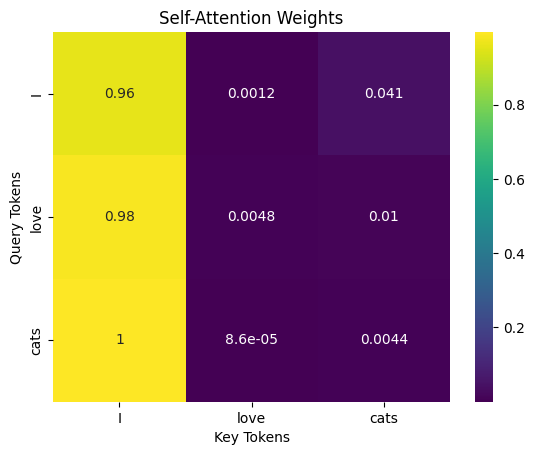

In [ ]:
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

tokens = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 2.0, 0.0, 2.0],
    [1.0, 1.0, 1.0, 1.0],
])

W_Q = torch.randn(4, 4)
W_K = torch.randn(4, 4)
W_V = torch.randn(4, 4)

Q = tokens @ W_Q
K = tokens @ W_K
V = tokens @ W_V

output, attn_weights = scaled_dot_product_attention(Q, K, V)

print("Attention Weights:\n", attn_weights)
print("Output:\n", output)

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attn, tokens_labels):
    sns.heatmap(attn.detach().numpy(), xticklabels=tokens_labels, yticklabels=tokens_labels, annot=True, cmap='viridis')
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.title("Self-Attention Weights")
    plt.show()

visualize_attention(attn_weights, ["I", "love", "cats"])

# Task 3

In [16]:
!pip install torchtext
!pip install --upgrade torch torchvision torchaudio torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 382.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 158.2/158.2 MB 169.4 MB/s eta 0:00:01^C


In [4]:
import torch
import torch.nn as nn
import math
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.size()
        qkv = self.qkv_proj(x).view(B, T, 3, self.num_heads, self.d_k)
        q, k, v = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        weights = torch.softmax(scores, dim=-1)
        attention = torch.matmul(weights, v)
        concat = attention.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(concat)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, num_classes, max_len=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads)
            for _ in range(num_layers)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x)
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)

dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)
    return {
        "input_ids": torch.tensor(tokens["input_ids"]),
        "label": torch.tensor(example["label"])
    }

train_dataset = dataset["train"].shuffle(seed=42).select(range(2000)).map(tokenize)
test_dataset = dataset["test"].select(range(500)).map(tokenize)

train_dataset.set_format(type="torch", columns=["input_ids", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "label"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoder(tokenizer.vocab_size, d_model=128, num_layers=2, num_heads=4, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x, y = batch["input_ids"].to(device), batch["label"].to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}")

model.eval()
correct = total = 0
with torch.no_grad():
    for batch in test_loader:
        x, y = batch["input_ids"].to(device), batch["label"].to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {correct / total:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Epoch 1, Train Loss: 44.4147
Epoch 2, Train Loss: 44.6306
Epoch 3, Train Loss: 43.3016
Test Accuracy: 1.0000


#Task 4

In [8]:
!pip install wandb

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import os
os.environ["WANDB_DISABLED"] = "true"

dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42).select(range(2000)),
    eval_dataset=tokenized_dataset["test"].select(range(500))
)

trainer.train()
results = trainer.evaluate()
print(results)


from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

import requests

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
response = requests.get(url)

with open("shakespeare.txt", "w", encoding="utf-8") as f:
    f.write(response.text)

print("shakespeare.txt downoaded")


dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="shakespeare.txt",
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./gpt2-shakespeare",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

trainer.train()

from transformers import pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(generator("To be, or not to be", max_length=50))


from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_text = "translate English to German: The house is wonderful."
input_ids = tokenizer.encode(input_text, return_tensors="pt")

output = model.generate(input_ids, max_length=40, num_beams=4, early_stopping=True)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss


{'eval_loss': 0.4600609242916107, 'eval_runtime': 13.345, 'eval_samples_per_second': 37.467, 'eval_steps_per_second': 4.721, 'epoch': 1.0}
shakespeare.txt downoaded


/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Step,Training Loss
500,3.808100
1000,3.584000
1500,3.481500
2000,3.461100
2500,3.424700
3000,3.401200
3500,3.368400
4000,3.359600
4500,3.348900
5000,3.331200


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'To be, or not to be, till it be in your head,\nAnd by your will will, i’ your will. My\nhusband, I love not myself. Your husband, it is no offence, but a\nlack'}]


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Das Haus ist wunderbar.


# Task 5

In [8]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install transformers datasets evaluate seqeval
!pip install wandb
!pip install conllu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
import spacy
import os
os.environ["WANDB_DISABLED"] = "true"

nlp = spacy.load("en_core_web_sm")
text = "Apple is planning to build a new campus in Austin by the end of 2025."
doc = nlp(text)

print("Named Entities, Phrases, and Labels:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_})")

from datasets import load_dataset
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import classification_report
import evaluate

dataset = load_dataset("conll2003")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=9)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"].select(range(1000)),
    eval_dataset=tokenized_dataset["validation"].select(range(200)),
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
results = trainer.evaluate()

print("Eval results:", results)

doc = nlp("The quick brown fox jumps over the lazy dog.")
print("POS Tags:")
for token in doc:
    print(f"{token.text} --> {token.pos_} ({token.tag_})")

from datasets import load_dataset

dataset = load_dataset("universal_dependencies", "en_lines")
print(dataset["train"][0]["tokens"])
print(dataset["train"][0]["upos"])

from sklearn.metrics import classification_report

true_tags = [...]
pred_tags = [...]

from sklearn.metrics import classification_report

flat_true_tags = [tag for seq in true_tags for tag in seq]
flat_pred_tags = [tag for seq in pred_tags for tag in seq]

print(classification_report(flat_true_tags, flat_pred_tags))

import evaluate
seqeval = evaluate.load("seqeval")
results = seqeval.compute(predictions=pred_tags, references=true_tags)
print(results)

Named Entities, Phrases, and Labels:
Apple (ORG)
Austin (GPE)
the end of 2025 (DATE)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-658853fc7d47>:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


Eval results: {'eval_loss': 0.16284149885177612, 'eval_runtime': 20.8251, 'eval_samples_per_second': 9.604, 'eval_steps_per_second': 1.2, 'epoch': 1.0}
POS Tags:
The --> DET (DT)
quick --> ADJ (JJ)
brown --> ADJ (JJ)
fox --> NOUN (NN)
jumps --> VERB (VBZ)
over --> ADP (IN)
the --> DET (DT)
lazy --> ADJ (JJ)
dog --> NOUN (NN)
. --> PUNCT (.)
['Show', 'All']
[16, 11]


TypeError: 'ellipsis' object is not iterable

  # Task 6

In [6]:
!pip install transformers datasets seqeval
!pip install wandb

In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from seqeval.metrics import precision_score, recall_score, f1_score
import numpy as np

dataset = load_dataset("conll2003")
label_list = dataset['train'].features['ner_tags'].feature.names

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(example["tokens"]))):
        labels = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)
            elif word_id != prev_word_id:
                labels.append(example["ner_tags"][i][word_id])
            else:
                labels.append(example["ner_tags"][i][word_id])
            prev_word_id = word_id
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))

args = TrainingArguments(
    output_dir="./ner_model",
    do_eval=True,
    save_strategy="no",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir='./logs',
)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds, labels)
    ]
    true_preds = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds, labels)
    ]
    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }


import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"].select(range(1000)),
    eval_dataset=tokenized_dataset["validation"].select(range(200)),
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-72253140c9a6>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'eval_loss': 0.3028041124343872, 'eval_precision': 0.7118380062305296, 'eval_recall': 0.6861861861861862, 'eval_f1': 0.6987767584097859, 'eval_runtime': 0.5106, 'eval_samples_per_second': 391.679, 'eval_steps_per_second': 25.459, 'epoch': 1.0}


# Task 7

In [5]:
!pip install transformers datasets scikit-learn torch
!python bert_sentiment_analysis.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

python3: can't open file '/content/bert_sentiment_analysis.py': [Errno 2] No such file or directory


In [3]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading dataset...")
dataset = load_dataset("imdb")

train_data = dataset["train"].select(range(5000))
test_data = dataset["test"].select(range(1000))

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

print("Tokenizing...")
train_data = train_data.map(tokenize_function, batched=True, batch_size=2000, load_from_cache_file=False)
test_data = test_data.map(tokenize_function, batched=True, batch_size=2000, load_from_cache_file=False)

train_data = train_data.remove_columns(["text"]).rename_column("label", "labels")
test_data = test_data.remove_columns(["text"]).rename_column("label", "labels")
train_data.set_format("torch")
test_data.set_format("torch")

print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

print("Starting training...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

print("Evaluating on test set...")
results = trainer.evaluate()
print("Accuracy:", results["eval_accuracy"])
print("F1 Score:", results["eval_f1"])

print("Generating confusion matrix...")
predictions = trainer.predict(test_data)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Using device: cuda
Loading dataset...
Tokenizing...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading BERT model...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-3-c6d8d8350893>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss
10,0.115700
20,0.000200
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000
90,0.000000
100,0.000000


Evaluating on test set...


Accuracy: 1.0
F1 Score: 0.0
Generating confusion matrix...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[1000]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Task 8


In [1]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-4-b9a099391b5e>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.680900
20,0.713800
30,0.682500
40,0.669400
50,0.628900
60,0.597800
70,0.467000
80,0.327000
90,0.434000
100,0.397500


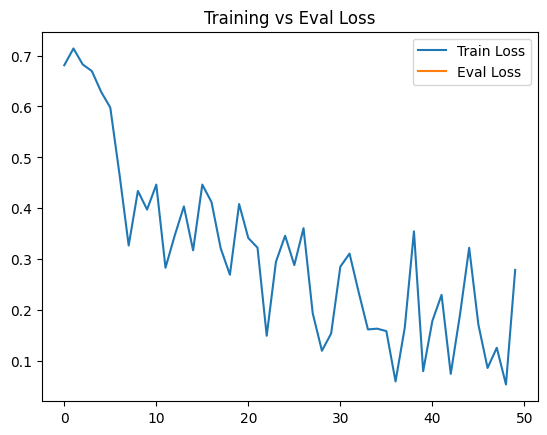

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from evaluate import load as load_metric
import numpy as np
import torch

import os
os.environ["WANDB_DISABLED"] = "true"
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

encoded = dataset.map(tokenize, batched=True)
encoded = encoded.rename_column("label", "labels")
encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)
metric = load_metric("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"].shuffle(seed=42).select(range(2000)),
    eval_dataset=encoded["test"].shuffle(seed=42).select(range(1000)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

import matplotlib.pyplot as plt
logs = trainer.state.log_history
loss = [x['loss'] for x in logs if 'loss' in x]
eval = [x['eval_loss'] for x in logs if 'eval_loss' in x]
plt.plot(loss, label="Train Loss")
plt.plot(eval, label="Eval Loss")
plt.legend()
plt.title("Training vs Eval Loss")
plt.show()
